# Gradient boosting
В этом задании будет использоваться датасет boston из sklearn.datasets. Оставьте последние 25% объектов для контроля качества, разделив X и y на X_train, y_train и X_test, y_test.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, model_selection, metrics, linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
dataset=datasets.load_boston()

In [3]:
dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
print (dataset['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
X=dataset['data']
y=dataset['target']
print(X.shape, y.shape)

(506, 13) (506,)


In [6]:
X_train=X[:round(-0.25*X.shape[0])]
y_train=y[:round(-0.25*y.shape[0])]

print (X_train.shape, y_train.shape)

(380, 13) (380,)


In [7]:
X_test=X[round(-0.25*X.shape[0]):]
y_test=y[round(-0.25*y.shape[0]):]

print (X_test.shape, y_test.shape)

(126, 13) (126,)


## Step 1.
Бустинг - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки. Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь L - квадрат отклонения ответа композиции a(x) от правильного ответа y на данном x.

После дифференцирования квадрата возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

$L(y, z) = (y - z)^2$\
$L'_z(y, z) = 2(z - y) =>(z - y)$

## Step 2.

Заведите массив для объектов DecisionTreeRegressor (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). 

В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X:

__def gbm_predict(X): return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]__
    
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics. Возведите результат в степень 0.5, чтобы получить RMSE.

In [8]:
def gbm_predict(X, base_algorithms_list, coefficients_list):
    return ([sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X])

In [9]:
base_algorithms_list1 = []
coefficients_list1 = []
train_scores1 = []
test_scores1 = []

for i in range(50):
    clf = DecisionTreeRegressor(max_depth = 5, random_state = 42)
    if i == 0:
        clf.fit(X_train, y_train)    
    else:
        prediction = gbm_predict(X_train, base_algorithms_list1, coefficients_list1)
        s = y_train - prediction
        clf.fit(X_train, s)
    
    base_algorithms_list1.append(clf)
    coefficients_list1.append(0.9)
    train_scores1.append(metrics.mean_squared_error(y_train, gbm_predict(X_train, base_algorithms_list1, coefficients_list1)))
    test_scores1.append(metrics.mean_squared_error(y_test, gbm_predict(X_test, base_algorithms_list1, coefficients_list1)))

Text(0, 0.5, 'MSE')

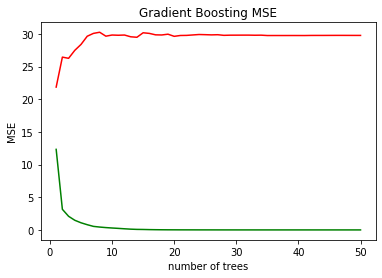

In [10]:
plt.plot(np.arange(1, 51, 1), test_scores1, label = 'test scores', color='r')
plt.plot(np.arange(1, 51, 1), train_scores1, label = 'train scores', color='g')
plt.title('Gradient Boosting MSE')
plt.xlabel('number of trees')
plt.ylabel('MSE')

In [11]:
metrics.mean_squared_error(y_test, gbm_predict(X_test, base_algorithms_list1, coefficients_list1))**0.5

5.4551393760319415

Text(0, 0.5, 'prediction')

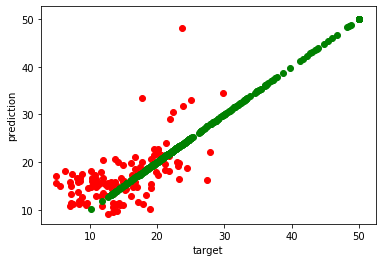

In [12]:
plt.scatter(y_test,gbm_predict(X_test, base_algorithms_list1, coefficients_list1), color='r')
plt.scatter(y_train,gbm_predict(X_train, base_algorithms_list1, coefficients_list1), color='g')
plt.xlabel('target')
plt.ylabel('prediction')

## Step 3.
Вас может также беспокоить, что при движении с постоянным шагом вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49).
В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным.

In [13]:
base_algorithms_list2 = []
coefficients_list2 = []
train_scores2 = []
test_scores2 = []

for i in range(50):
    clf = DecisionTreeRegressor(max_depth = 5, random_state = 42)
    if i == 0:
        clf.fit(X_train, y_train)    
    else:
        prediction = gbm_predict(X_train, base_algorithms_list2, coefficients_list2)
        s = y_train - prediction
        clf.fit(X_train, s)
    
    base_algorithms_list2.append(clf)
    coefficients_list2.append(0.9/(1.0+i))
    train_scores2.append(metrics.mean_squared_error(y_train, gbm_predict(X_train, base_algorithms_list2, coefficients_list2)))
    test_scores2.append(metrics.mean_squared_error(y_test, gbm_predict(X_test, base_algorithms_list2, coefficients_list2)))

Text(0, 0.5, 'MSE')

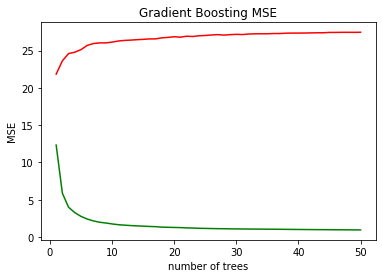

In [14]:
plt.plot(np.arange(1, 51, 1), test_scores2, label = 'test scores', color='r')
plt.plot(np.arange(1, 51, 1), train_scores2, label = 'train scores', color='g')
plt.title('Gradient Boosting MSE')
plt.xlabel('number of trees')
plt.ylabel('MSE')

In [15]:
metrics.mean_squared_error(y_test, gbm_predict(X_test, base_algorithms_list2, coefficients_list2))**0.5

5.241033584774468

Text(0, 0.5, 'prediction')

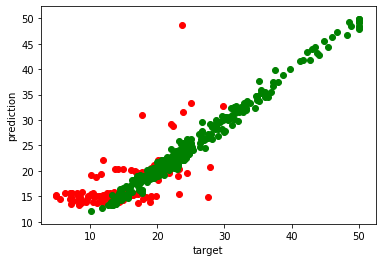

In [16]:
plt.scatter(y_test,gbm_predict(X_test, base_algorithms_list2, coefficients_list2), color='r')
plt.scatter(y_train,gbm_predict(X_train, base_algorithms_list2, coefficients_list2), color='g')
plt.xlabel('target')
plt.ylabel('prediction')

## Step 4.

Реализованный метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке sklearn, так и в сторонней библиотеке XGBoost, которая имеет свой питоновский интерфейс. На практике XGBoost работает заметно лучше GradientBoostingRegressor из sklearn. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев.

1) (False) С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

2) (True) С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

3) (True) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться

4) (False) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

### Зависимость от числа деревьев

In [17]:
number_trees = np.arange(5, 1000, 5)
train_scores3 = []
test_scores3 = []

for tree in number_trees:
    regressor = GradientBoostingRegressor(n_estimators = tree)
    regressor.fit(X_train, y_train)
    train_scores3.append(metrics.mean_squared_error(y_train, regressor.predict(X_train)))
    test_scores3.append(metrics.mean_squared_error(y_test, regressor.predict(X_test)))

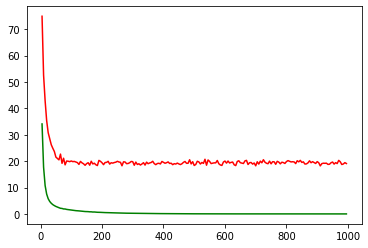

In [18]:
plt.plot(number_trees,train_scores3, color='g')
plt.plot(number_trees,test_scores3, color='r')

### Зависимость от глубины дерева

In [19]:
tree_depth = np.arange(1, 50, 1)
train_scores4 = []
test_scores4 = []

for depth in tree_depth:
    regressor = GradientBoostingRegressor(max_depth=depth)
    regressor.fit(X_train, y_train)
    train_scores4.append(metrics.mean_squared_error(y_train, regressor.predict(X_train)))
    test_scores4.append(metrics.mean_squared_error(y_test, regressor.predict(X_test)))

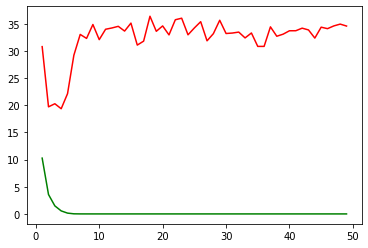

In [20]:
plt.plot(tree_depth,train_scores4, color='g')
plt.plot(tree_depth,test_scores4, color='r')

## Step 5.

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE. В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда.

In [21]:
clf=linear_model.LinearRegression()
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
metrics.mean_squared_error(y_test, clf.predict(X_test))**0.5

7.819688142087171

Text(0, 0.5, 'prediction')

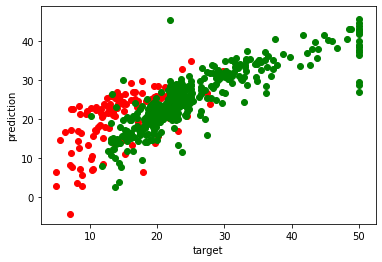

In [23]:
plt.scatter(y_test, clf.predict(X_test), color = 'r')
plt.scatter(y_train, clf.predict(X_train), color = 'g')
plt.xlabel('target')
plt.ylabel('prediction')